In [1]:
#ignore annoying deprecation warnings
import warnings
warnings.filterwarnings('ignore')

# Neural Networks in Python!


## Introduction

An artificial **neural network** is a computing system whose design is (roughly) inspired by the biological neural networks that constitute the brains of animals, including humans. A neural network can learn to perform a task simply by considering examples. This learning occurs automatically (i.e., there is no need to provide a neural network with any task-specific rules). For example, a neural network can learn to accurately identify images that contain cats simply by analyzing images that have been labeled as "cat" or "no cat". After being trained, the neural network can then accurately identify cats in other images that it has not previously "seen". Importantly, the neural network in this example can learn to identify cats without having any prior knowledge about what constitutes a cat (e.g., the neural network does not know that cats have a tail, whiskers, soft fur, four legs, etc.). Instead, the neural network automatically identifies characteristics in the training examples with which it is provided that can accurately distinguish "catness" from "non catness".

Architecturally, an artificial neural network is simply a collection of interconnected nodes (artificial neurons) that loosely model the neurons in a biological brain. Each inter-node connection, like the synapses in a biological brain, can transmit a signal from one node to another. A node that receives a signal can process the signal and then send additional signals to the other nodes to which it is connected. The signals that are sent between nodes are typically real numbers, with the output of each node being determined by a function of the node's inputs. Each node and each connection typically have real-numbered weights whose values are automatically adjusted during the learning process. These weights increase or decrease the strength of the signal that is sent across a connection. Nodes are ususally aggregated into layers, with signals traveling from the first layer (known as the *input layer*) through one or more intermediate layers (known as *hidden layers*), and finally to the last layer (known as the *output layer*). These concepts are illustrated in the image below:
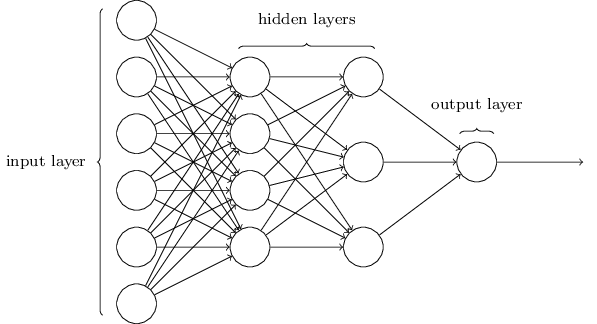

## Load Libraries and Data

In this lesson, we'll be using the *iris* data that we used in a few of our previous lessons to learn how to train and evaluate the performance of a neural network in Python. Spcifically, our goal will be to train a neural network that can autoatically identify the correct species of an iris flower based on measurements of the flower's petals and sepals. Here's an image that illustrates the parts of a flower:

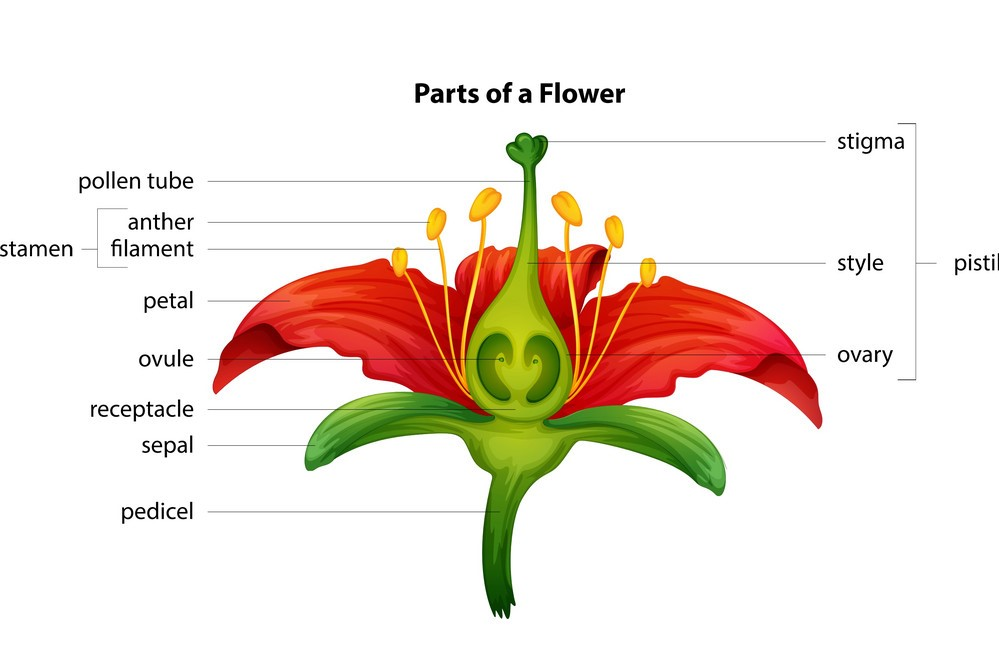

We'll be using the `neural_network` package from **scikit-learn** to actually build and train our neural network.

In [2]:
#install the pandas_ml package
!pip install pandas_ml

#import packages
from pandas_ml import ConfusionMatrix
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from statsmodels.api import datasets
import sklearn.model_selection as ms
import sklearn.metrics as sklm
import pandas as pd
import numpy as np
import numpy.random as nr

#get the iris dataset and assign it to a pandas dataframe
df = datasets.get_rdataset("iris").data
df.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width', 'Species']

#view the first 10 rows of data in the dataframe
df.head(10)

    100% |████████████████████████████████| 81kB 827kB/s ta 0:00:01
  Running setup.py bdist_wheel for pandas-ml ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/4b/b0/88/51fb7203a0f81becae3e92d5bf9fee0460375e5408e67a7dc3
Successfully built pandas-ml
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Sepal_Length  Sepal_Width  Petal_Length  Petal_Width Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
5           5.4          3.9           1.7          0.4  setosa
6           4.6          3.4           1.4          0.3  setosa
7           5.0          3.4           1.5          0.2  setosa
8           4.4          2.9           1.4          0.2  setosa
9           4.9          3.1           1.5          0.1  setosa

Again, our goal in this lesson will be to correctly identify the species of each iris based on its sepal length, sepal width, petal length, and petal width.

## Data Preparation

#### Recoding the 'Species' Variable
As shown in the table above, each iris's species is currently recorded using textual labels (*setosa*, *versicolor*, and *virginica*. We will need to convert these values into a numerically coded variable before building our neural network:

In [3]:
#define a dictionary that specifies current and replacement values
speciesCodes = {'setosa': 0, 'versicolor': 1, 'virginica': 2}

#use the dictionary to create a new variable that contains numerically coded species values
df['Species_Code'] = df['Species'].replace(speciesCodes)

#view the first 10 rows of data in the dataframe
df.head(10)

Sepal_Length  Sepal_Width  Petal_Length  Petal_Width Species  Species_Code
0           5.1          3.5           1.4          0.2  setosa             0
1           4.9          3.0           1.4          0.2  setosa             0
2           4.7          3.2           1.3          0.2  setosa             0
3           4.6          3.1           1.5          0.2  setosa             0
4           5.0          3.6           1.4          0.2  setosa             0
5           5.4          3.9           1.7          0.4  setosa             0
6           4.6          3.4           1.4          0.3  setosa             0
7           5.0          3.4           1.5          0.2  setosa             0
8           4.4          2.9           1.4          0.2  setosa             0
9           4.9          3.1           1.5          0.1  setosa             0

As shown above, each species of iris has been coded with a number (*0*, *1*, or *2*, indicating *setosa*, *versicolor*, or *virginica*, respectively).

#### Checking for Class Imbalance
Next, we'll check whether there is an approximately equal number of each species of iris in the data set. If the number of irises of each species is imbalanced, then we may need to construct a balanced data set before proceeding:

In [4]:
#show case counts each species of iris in the dataframe
print('Species value counts:')
print(df['Species'].value_counts())
print('Species code value counts:')
print(df['Species_Code'].value_counts())

Species value counts:
versicolor    50
setosa        50
virginica     50
Name: Species, dtype: int64
Species code value counts:
2    50
1    50
0    50
Name: Species_Code, dtype: int64


The values shown above indicate that our data set contains exactly 50 cases of each of the three species of iris.. There are an equal number of cases of each species, so we can proceed with our analysis.

#### Checking for Skewed and Kurtotic Data
Next, we'll check whether our input variables have acceptable levels of skew and kurtosis. Neural networks are relatively robust to non-normal input data, but highly skewed or highly kurtotic distributions could be indicative of an underlying problem with the sample data. Let's look at the skew and kurtosis for our input variables:

In [5]:
#show skewness and kurtosis for input variables
print('Skew: ')
print(df[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']].skew())
print('Kurtosis: ')
print(df[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']].kurt())

Skew: 
Sepal_Length    0.314911
Sepal_Width     0.318966
Petal_Length   -0.274884
Petal_Width    -0.102967
dtype: float64
Kurtosis: 
Sepal_Length   -0.552064
Sepal_Width     0.228249
Petal_Length   -1.402103
Petal_Width    -1.340604
dtype: float64


The results show that the levels of skew for all of the input variables fall within the acceptable range (-0.5 to 0.5), and that the levels of kurtosis for all of the variables also fall within the acceptable range (-3.0 to 3.0). We can therefore proceed without needing to consider any numeric transformations.

#### Normalizing (Rescaling) the Data
The four variables that we'll be using as the basis for our classification (*Sepal_Length*, *Sepal_Width*, *Petal_Length*, and *Petal_Width*) have very different distributions, as revealed by the descriptive statistics below:

In [6]:
#show descriptives for the input variables
df[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']].describe().transpose()

count      mean       std  min  25%   50%  75%  max
Sepal_Length  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9
Sepal_Width   150.0  3.057333  0.435866  2.0  2.8  3.00  3.3  4.4
Petal_Length  150.0  3.758000  1.765298  1.0  1.6  4.35  5.1  6.9
Petal_Width   150.0  1.199333  0.762238  0.1  0.3  1.30  1.8  2.5

Since neural networks are sensitive to scaling differences among the input variables (i.e., they are not scale invariant), it is important to normalize (rescale) our input variables to ensure that the distributional differences between our variables are minimized:

In [7]:
#define a standard (z-score) scaler object
scaler = preprocessing.StandardScaler()

#perform z-score normalization on all of the input variables
z_score_scaled = scaler.fit_transform(df[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']])

#convert the numpy ndarray into a pandas dataframe
z_score_scaled = pd.DataFrame(z_score_scaled)

#name the columns in the new dataframe
z_score_scaled.columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']

#construct a data frame containing all five variables
df = pd.concat([df['Species_Code'], z_score_scaled], axis=1)

#view descriptive statistics
df.describe()

Species_Code  Sepal_Length   Sepal_Width  Petal_Length   Petal_Width
count    150.000000  1.500000e+02  1.500000e+02  1.500000e+02  1.500000e+02
mean       1.000000 -2.775558e-16 -9.695948e-16 -8.652338e-16 -4.662937e-16
std        0.819232  1.003350e+00  1.003350e+00  1.003350e+00  1.003350e+00
min        0.000000 -1.870024e+00 -2.433947e+00 -1.567576e+00 -1.447076e+00
25%        0.000000 -9.006812e-01 -5.923730e-01 -1.226552e+00 -1.183812e+00
50%        1.000000 -5.250608e-02 -1.319795e-01  3.364776e-01  1.325097e-01
75%        2.000000  6.745011e-01  5.586108e-01  7.627583e-01  7.906707e-01
max        2.000000  2.492019e+00  3.090775e+00  1.785832e+00  1.712096e+00

Our input variables have been successfully rescaled into z-scores, so we can now proceed with splitting our data.

#### Training and Testing Data
Next, let's subdivide our data set into training and testing sets. This step is critically important -- if a neural network model is evaluated using only the data that were used to train the model, then the results will be both biased and overly optimistic for real-world scenarios.

For our purposes, we will create a training set that contains 70% of our data, while the testing set will contain the remaining 30% of the data:

In [8]:
#define a random seed to ensure that the results are consistent
np.random.seed(1234)

#compute the size of the testing data set
test_size = int(df.shape[0] * 0.3) #30% of the data will be used for testing

#use Bernoulli sampling to get a two-dimensional array that contains the indexes of the rows that will comprise the training and testing data sets
indexes = ms.train_test_split(range(df.shape[0]), test_size = test_size)

#define the training data set
training = df.iloc[indexes[0],:]

#define the testing data set
testing = df.iloc[indexes[1],:]

Now that we've completed preparing our data, let's build and train our neural network!

## Build and Train the Neural Network
Next, we'll use our **training data** to build and train our neural network model. To build and train the model, we will:
1. Define a neural network (multilayer perceptron - MLP) model object using the `MLPClassifier` method from the scikit-learn `neural_network` package.
2. Train the neural network model using the predictor and outcome variables from our **training** data set:

In [9]:
#define and train the neural network
nn_mod = MLPClassifier(hidden_layer_sizes = (50,)) 
nn_mod.fit(training[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']], training['Species_Code'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Notice that the configuration of the model object is printed during the estimation process. In our case, we have defined a model with one hidden layer that contains 50 nodes.

Next, let's use our trained neural network to get all of the species predictions for our **testing** data:

In [10]:
#calculate species predictions for the irises in the testing data set
species_predictions = nn_mod.predict(testing[['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']])

#show the first 10 species code predictions for the testing data
print(species_predictions[:10])

[1 1 2 0 1 0 0 0 1 2]


Now that we have our species code predictions for the irises in the testing data set, let's see how well our neural network actually works at classifying iris species:

## Evaluate the Neural Network
The most common way to evaluate the performance of a neural network-based classifier is to use a **confusion matrix**. A confusion matrix displays the number of correctly and incorrectly classified cases in a tabular format. Once this step is complete, the values in the confusion matrix can be used to compute a wide variety of performance statistics, including overall accuracy, precision, recall, F1, etc.

for our purposes, we will use the `ConfusionMatrix` function from the *pandas_ml* package in order to compute our confusion matrix and its associated performance statistics:

In [11]:
#compute and display a confusion matrix and its associated performance metrics
confusion_matrix = ConfusionMatrix(testing['Species_Code'].values, species_predictions)
confusion_matrix.print_stats()

Confusion Matrix:

Predicted   0   1   2  __all__
Actual                        
0          16   0   0       16
1           0  15   2       17
2           0   0  12       12
__all__    16  15  14       45


Overall Statistics:

Accuracy: 0.9555555555555556
95% CI: (0.8485070997566608, 0.9945715112997491)
No Information Rate: ToDo
P-Value [Acc > NIR]: 2.0602249497411565e-17
Kappa: 0.9331352154531948
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                       0          1          2
Population                                   45         45         45
P: Condition positive                        16         17         12
N: Condition negative                        29         28         33
Test outcome positive                        16         15         14
Test outcome negative                        29         30         31
TP: True Positive                            16         15         12
TN: True Negative                            29         28

As you can see, our neural network model is about 96% accurate overall in predicting an iris flower's species based on its sepal and petal widths and heights. Recalling that our species were coded as *0 = setosa*, *1 = versicolor*, and *2 = virginica*, the confusion matrix indicates that the only mistakes that our neural network made was in predicting that two of the irises were versicolors when they were actually virginicas.